In [228]:
%run PBM.ipynb
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from scipy.integrate import solve_ivp
from sklearn.linear_model import LinearRegression

# Data import

In [237]:
df = pd.read_csv('particle_size.csv')
data = df.to_numpy()
size= data[:,0]
V = data[:,1:]/100
N = np.empty((61,6))
df2 = pd.read_csv('lognormal.csv')
data2 = df2.to_numpy()
mu = data2[0:4,-1]
sigma = data2[4:,-1]
T = np.array([0.,44.,88.,154.,330.,551.])

In [267]:
mu

array([ 3.89876,  2.02216,  0.68892, -0.91977])

In [273]:
np.exp(mu)

array([49.34122803,  7.55462531,  1.99156348,  0.39861071])

## Particle size
Mean particle size of miroflocs, primary particles, colloidal substances are decreasing as sonication time increases. Simple linear regression was adopted for mean particle size reduction.

In [212]:
t = T.reshape((-1,1))[1:]

In [216]:
mm = LinearRegression().fit(t, mu[1,1:])
pm = LinearRegression().fit(t, mu[2,1:])
cm = LinearRegression().fit(t, mu[3,1:])

In [217]:
def mu_micro(T):
    return mm.predict(T)
def mu_primary(T):
    return pm.predict(T)
def mu_colloidal(T):
    return cm.predict(T)

In [193]:
ynew = model.predict(x)

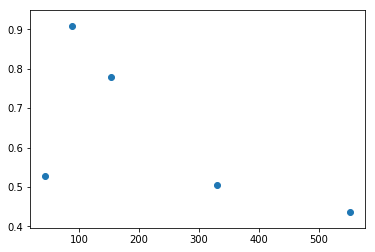

In [224]:
plt.scatter(T,sigma[3])

In [251]:
sigma[2]

0.9321221825980981

In [4]:
# geometric mean size
ls = np.array([0,0.54876,0.52198,0.51649,0.40762,0.39730])
lp = np.array([0,4.69829,4.08432,3.09635,2.52168,2.27651])
lm = np.array([16.03061,17.17078,12.63863,10.63114,8.22754,7.63467])
# geometric standard deviation
ss = np.array([0,3.93224,3.90796,3.91075,3.11803,2.76949])
sp = np.array([0,7.09594,6.64707,6.08667,10.75202,12.10264])
sm = np.array([5.13665,4.85233,4.11311,3.85168,3.86056,3.98997])

## Data interpolation
Since PBM has limitation on selection of particle size such as $l_{i+1}=2^{1/3}l_i$, size from the instrument should be interpolated to the size suitable to PBM. Cubic spline was adopted for the interpolation.

In [230]:
n = 41
L = np.empty(n)
L[0] = size[0]
for i in range(n-1):
    L[i+1] = L[i]*2**(1/3)

In [231]:
Vcs = np.empty((n,6))
for i in range(6):
    Vcs[:,i] = CubicSpline(size,V[:,i])(L)

# Convert volume to number
Simple relation between volume and number
\begin{equation}
V_i=N_i\times l_i^3
\end{equation}
was assumed.

In [232]:
N = np.empty((n,6))
for i in range(6):
    N[:,i] = np.divide(Vcs[:,i],L**3)

In [233]:
N0 = N[:,0]
m00 = np.sum(N0)
m10 = np.sum(L@N0)
m20 = np.sum(np.power(L,2)@N0)
m30 = np.sum(np.power(L,3)@N0)
Y0 = np.append(N0,[m00,m10,m20,m30])

## Breakage function by log normal distribution

In [258]:
# microfloc
b1 = 1.0
# primary particle
b2 = 0.0
# colloidal substances
b3 = 1.0-b1-b2
def breakfunc(x,l):
    bf=b1*lognorm_b(x,l,mu[1],sigma[1])+b2*lognorm_b(x,l,mu[2],sigma[2])+b3*lognorm_b(x,l,mu[3],sigma[3])
    return bf

## Selection function
\begin{equation}
S(l)=S_0l^p
\end{equation}

In [235]:
S0 = 1e-4
p = 3
def selectionfunc(l):
    return S0*l**p

In [259]:
bmat = breakage_mat(selectionfunc,breakfunc,L,n)
Svec = selection_rate(selectionfunc,breakfunc,L,n,bmat)

calculating breakage matrix
calculating selection vector


In [240]:
def dydx(t,y):
    return breakage(y,bmat,Svec)

In [260]:
sol = solve_ivp(dydx,[T[0],T[-1]],Y0,method='Radau',t_eval=T)
N = sol.y[0:-4,:]
M = sol.y[-4:,:]
V= np.empty(np.shape(N))
for i in range(6):
    V[:,i] = np.multiply(N[:,i],L**3)

(2, 0)

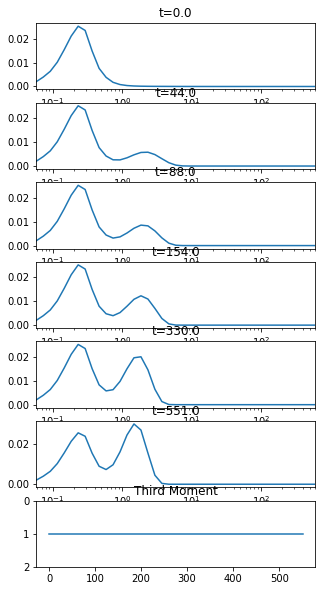

In [261]:
rows = len(T)
plt.close('all')
fig, axes = plt.subplots(rows+1,1,figsize=(5,10))
for i in range(rows):
    axes[i].plot(L,N[:,i])
    axes[i].set_xscale('log')
    axes[i].set_xlim([L[0],L[-1]])
    axes[i].title.set_text('t={0}'.format(T[i]))
M_norm = np.empty(np.shape(M))
for i in range(4):
    M_norm[i,:] = M[i,:]/M[i,0]
axes[rows].plot(T,M_norm[-1,:])
axes[rows].title.set_text('Third Moment')
axes[rows].set_ylim([2,0])

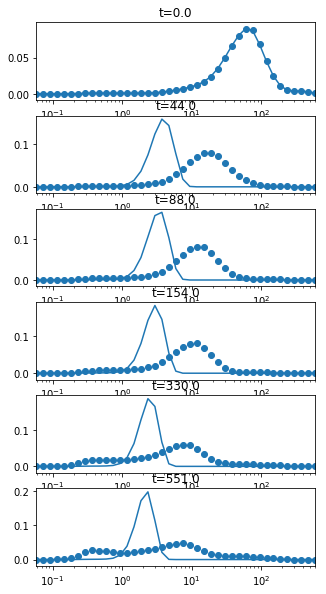

In [262]:
fig, axes = plt.subplots(rows,1,figsize=(5,10))
for i in range(rows):
    axes[i].plot(L,V[:,i])
    axes[i].scatter(L,Vcs[:,i])
    axes[i].set_xscale('log')
    axes[i].set_xlim([L[0],L[-1]])
    axes[i].title.set_text('t={0}'.format(T[i]))

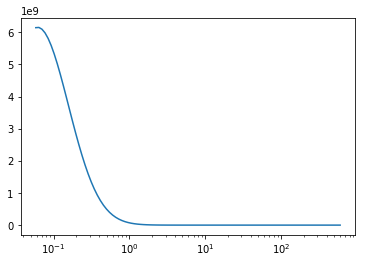

In [271]:
xx = np.logspace(np.log10(L[0]),np.log10(L[-1]),100)
plt.plot(xx,lognorm_b(xx,L[-1],mu[2],sigma[2]))
plt.xscale('log')

In [252]:
def lnpdf(x,mu,sigma):
    return np.exp(-(np.log(x)-mu)**2/(2*sigma**2))/(x*sigma*np.sqrt(2*np.pi))

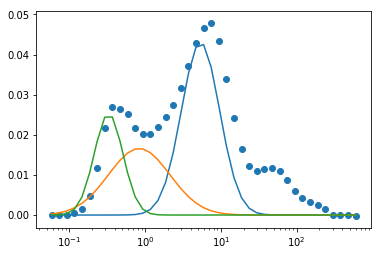

In [295]:
plt.plot(L,lnpdf(L,mu[1],sigma[1])/2.5)
plt.plot(L,lnpdf(L,mu[2],sigma[2])/20)
plt.plot(L,lnpdf(L,mu[3],sigma[3])/100)
plt.scatter(L,Vcs[:,5])
plt.xscale('log')

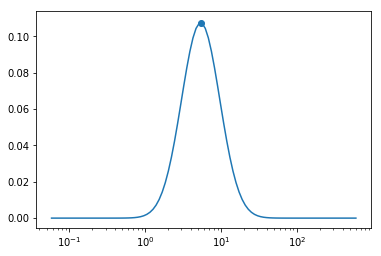

In [298]:
xx = np.logspace(np.log10(L[0]),np.log10(L[-1]),100)
pdf = lnpdf(xx,mu[1],sigma[1])
plt.plot(xx,pdf)
plt.xscale('log')
plt.scatter(np.exp(mu[1]-sigma[1]**2),max(pdf))

In [299]:
print(np.exp(mu[1]-sigma[1]**2))

5.387603389310469


In [300]:
def npdf(x,mu,sigma):
    return np.exp(-((x-mu)/sigma)**2/2)/(sigma*np.sqrt(2*np.pi))

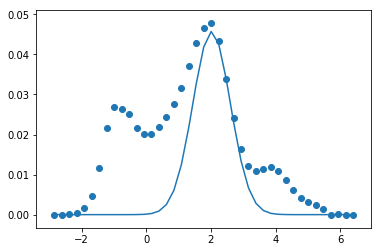

In [338]:
plt.plot(np.log(L),npdf(np.log(L),mu[1],sigma[1])/15)
plt.scatter(np.log(L),Vcs[:,5])

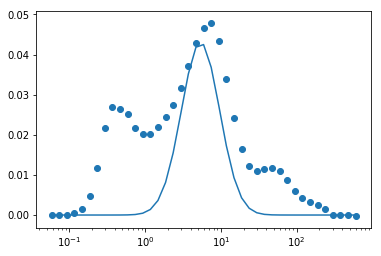

In [353]:
i=1
plt.plot(L,lnpdf(L,mu[i],sigma[i])/2.5)
plt.scatter(L,Vcs[:,5])
plt.xscale('log')

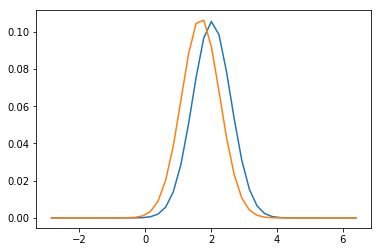

In [367]:
plt.plot(np.log(L),npdf(np.log(L),mu[1],sigma[1])/6.5)
plt.plot(np.log(L),lnpdf(L,mu[1],sigma[1]))

In [328]:
variance

32.18925007382119

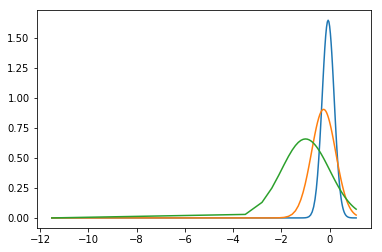

In [323]:
xx = np.linspace(1e-5,3,100)
plt.plot(np.log(xx),lnpdf(xx,0,0.25))
plt.plot(np.log(xx),lnpdf(xx,0,0.5))
plt.plot(np.log(xx),lnpdf(xx,0,1))